<a href="https://colab.research.google.com/github/jfffffffffff/An-lisis-de-caracter-sticas-biol-gicas/blob/main/Tarea_de_redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Carga y preprocesamiento de datos
Primero, necesitamos cargar el conjunto de datos MNIST usando torchvision y DataLoader.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import time
import numpy as np

# Definir las transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar los conjuntos de datos


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Crear DataLoaders
batch_size = 64 # Definir un tamaño de batch inicial
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]

Usando dispositivo: cuda


# 2. Definición de modelos

Ahora definiremos las dos arquitecturas de red neuronal: FC y CNN.

Modelo A: Red totalmente conectada (FC)

In [2]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Modelo B: Red convolucional (CNN)

In [3]:
class CNNNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calcular el tamaño de la entrada lineal después de las capas convolucionales y de pooling
        # MNIST image size is 28x28
        # After conv1 and pool1: (28/2) * (28/2) = 14x14, with 32 channels
        # After conv2 and pool2: (14/2) * (14/2) = 7x7, with 64 channels
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# 3. Sintonización de hiperparámetros

Para la sintonización de hiperparámetros, podemos usar una búsqueda en cuadrícula (grid search) o una búsqueda aleatoria (random search). Aquí te presento un ejemplo de cómo podrías implementar una búsqueda en cuadrícula simple para la tasa de aprendizaje y el tamaño del batch. Para este ejemplo, sintonizaremos estos dos hiperparámetros para el modelo FC.

Primero, definimos una función para entrenar y evaluar un modelo con un conjunto dado de hiperparámetros.



In [4]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training Time: {training_time:.2f} seconds')

    return test_accuracies[-1], training_time, train_losses, test_losses, test_accuracies

Ahora, realizamos la búsqueda en cuadrícula:

In [5]:
# Definir el espacio de búsqueda de hiperparámetros
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64, 128]
hidden_sizes_fc = [64, 128] # Hiperparámetro para el modelo FC

best_accuracy = 0
best_params = {}
results = []

for lr in learning_rates:
    for bs in batch_sizes:
        # Recrear DataLoader con el nuevo tamaño de batch
        trainloader_tuned = DataLoader(trainset, batch_size=bs, shuffle=True)
        testloader_tuned = DataLoader(testset, batch_size=bs, shuffle=False)

        for hs in hidden_sizes_fc:
            print(f"\nEntrenando FC con LR: {lr}, Batch Size: {bs}, Hidden Size: {hs}")

            # Inicializar el modelo FC
            model_fc_tuned = FCNet(input_size=28*28, hidden_size=hs, num_classes=10).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model_fc_tuned.parameters(), lr=lr)

            accuracy, training_time, train_losses, test_losses, test_accuracies = train_and_evaluate(
                model_fc_tuned, trainloader_tuned, testloader_tuned, criterion, optimizer, num_epochs=5 # Usar menos épocas para la sintonización
            )

            results.append({
                'model': 'FC',
                'lr': lr,
                'batch_size': bs,
                'hidden_size': hs,
                'accuracy': accuracy,
                'training_time': training_time
            })

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': bs, 'hidden_size': hs}

print("\nMejores parámetros encontrados para FC:", best_params)
print("Mejor Accuracy en validación para FC:", best_accuracy)

# Puedes replicar este proceso para sintonizar hiperparámetros del modelo CNN (ej. lr, batch_size, kernel_size, número de filtros)


Entrenando FC con LR: 0.001, Batch Size: 32, Hidden Size: 64
Epoch 1/5, Train Loss: 0.3935, Test Loss: 0.2454, Test Accuracy: 0.9270
Epoch 2/5, Train Loss: 0.2163, Test Loss: 0.1729, Test Accuracy: 0.9489
Epoch 3/5, Train Loss: 0.1704, Test Loss: 0.1478, Test Accuracy: 0.9540
Epoch 4/5, Train Loss: 0.1455, Test Loss: 0.1540, Test Accuracy: 0.9517
Epoch 5/5, Train Loss: 0.1300, Test Loss: 0.1614, Test Accuracy: 0.9527
Training Time: 80.73 seconds

Entrenando FC con LR: 0.001, Batch Size: 32, Hidden Size: 128
Epoch 1/5, Train Loss: 0.3488, Test Loss: 0.1944, Test Accuracy: 0.9391
Epoch 2/5, Train Loss: 0.1744, Test Loss: 0.1456, Test Accuracy: 0.9524
Epoch 3/5, Train Loss: 0.1298, Test Loss: 0.1291, Test Accuracy: 0.9629
Epoch 4/5, Train Loss: 0.1102, Test Loss: 0.1057, Test Accuracy: 0.9657
Epoch 5/5, Train Loss: 0.0932, Test Loss: 0.1051, Test Accuracy: 0.9694
Training Time: 77.96 seconds

Entrenando FC con LR: 0.001, Batch Size: 64, Hidden Size: 64
Epoch 1/5, Train Loss: 0.4262, Test

Explicación del proceso de sintonización (Grid Search):

Definir el espacio de búsqueda: Especificamos una lista de valores posibles para cada hiperparámetro que queremos sintonizar (tasa de aprendizaje, tamaño del batch, tamaño de la capa oculta en FC).
Iterar a través de las combinaciones: El código itera sobre todas las combinaciones posibles de los hiperparámetros definidos.
Entrenar y evaluar: Para cada combinación de hiperparámetros, se inicializa un nuevo modelo con esos parámetros, se entrena durante un número fijo de épocas y se evalúa su rendimiento (en este caso, la precisión) en el conjunto de prueba (o validación, si se usa).
Registrar resultados: Se registran los hiperparámetros y el rendimiento obtenido.
Identificar los mejores parámetros: Después de probar todas las combinaciones, se identifican los hiperparámetros que resultaron en el mejor rendimiento.

4. Evaluación

Una vez que hayas sintonizado los hiperparámetros y elegido los mejores para cada modelo (o si decides usar valores predeterminados si no haces sintonización extensiva), puedes proceder a la evaluación final.

Primero, entrenamos los modelos finales con los mejores hiperparámetros (o los predeterminados).

In [6]:
# Usar los mejores parámetros encontrados para FC o definir unos si no sintonizaste
best_lr_fc = best_params.get('lr', 0.001)
best_batch_size_fc = best_params.get('batch_size', 64)
best_hidden_size_fc = best_params.get('hidden_size', 128)

# Recrear DataLoader con el mejor tamaño de batch para FC
trainloader_fc_final = DataLoader(trainset, batch_size=best_batch_size_fc, shuffle=True)
testloader_fc_final = DataLoader(testset, batch_size=best_batch_size_fc, shuffle=False)

# Inicializar y entrenar el modelo FC final
model_fc_final = FCNet(input_size=28*28, hidden_size=best_hidden_size_fc, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_fc = optim.Adam(model_fc_final.parameters(), lr=best_lr_fc)

print("\n--- Entrenando Modelo FC Final ---")
accuracy_fc, training_time_fc, train_losses_fc, test_losses_fc, test_accuracies_fc = train_and_evaluate(
    model_fc_final, trainloader_fc_final, testloader_fc_final, criterion, optimizer_fc, num_epochs=10 # Más épocas para el entrenamiento final
)

# Puedes sintonizar hiperparámetros para CNN de manera similar o usar valores predeterminados
# Valores predeterminados para CNN si no sintonizaste extensivamente
lr_cnn = 0.001
batch_size_cnn = 64

trainloader_cnn_final = DataLoader(trainset, batch_size=batch_size_cnn, shuffle=True)
testloader_cnn_final = DataLoader(testset, batch_size=batch_size_cnn, shuffle=False)

# Inicializar y entrenar el modelo CNN final
model_cnn_final = CNNNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn_final.parameters(), lr=lr_cnn)

print("\n--- Entrenando Modelo CNN Final ---")
accuracy_cnn, training_time_cnn, train_losses_cnn, test_losses_cnn, test_accuracies_cnn = train_and_evaluate(
    model_cnn_final, trainloader_cnn_final, testloader_cnn_final, criterion, optimizer_cnn, num_epochs=10
)


--- Entrenando Modelo FC Final ---
Epoch 1/10, Train Loss: 0.3855, Test Loss: 0.2450, Test Accuracy: 0.9325
Epoch 2/10, Train Loss: 0.2016, Test Loss: 0.1605, Test Accuracy: 0.9524
Epoch 3/10, Train Loss: 0.1431, Test Loss: 0.1270, Test Accuracy: 0.9617
Epoch 4/10, Train Loss: 0.1169, Test Loss: 0.1064, Test Accuracy: 0.9691
Epoch 5/10, Train Loss: 0.0956, Test Loss: 0.0972, Test Accuracy: 0.9693
Epoch 6/10, Train Loss: 0.0842, Test Loss: 0.0881, Test Accuracy: 0.9735
Epoch 7/10, Train Loss: 0.0742, Test Loss: 0.0980, Test Accuracy: 0.9709
Epoch 8/10, Train Loss: 0.0702, Test Loss: 0.0886, Test Accuracy: 0.9726
Epoch 9/10, Train Loss: 0.0615, Test Loss: 0.0972, Test Accuracy: 0.9704
Epoch 10/10, Train Loss: 0.0566, Test Loss: 0.0837, Test Accuracy: 0.9739
Training Time: 136.77 seconds

--- Entrenando Modelo CNN Final ---
Epoch 1/10, Train Loss: 0.1629, Test Loss: 0.0676, Test Accuracy: 0.9789
Epoch 2/10, Train Loss: 0.0496, Test Loss: 0.0392, Test Accuracy: 0.9875
Epoch 3/10, Train Lo

Ahora, realizamos las métricas de evaluación.

In [7]:
# Función para calcular métricas de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy()) # Obtener probabilidades para AUC

    accuracy = accuracy_score(y_true, y_pred)
    # Calcular AUC One-vs-Rest
    y_true_one_hot = np.eye(10)[y_true]
    auc = roc_auc_score(y_true_one_hot, y_scores, multi_class='ovr')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, auc, conf_matrix, y_true, y_scores

# Evaluar el modelo FC final
accuracy_fc_eval, auc_fc, conf_matrix_fc, y_true_fc, y_scores_fc = evaluate_model(model_fc_final, testloader_fc_final)

# Evaluar el modelo CNN final
accuracy_cnn_eval, auc_cnn, conf_matrix_cnn, y_true_cnn, y_scores_cnn = evaluate_model(model_cnn_final, testloader_cnn_final)

print("\n--- Resultados de Evaluación ---")
print(f"Modelo FC:")
print(f"  Accuracy: {accuracy_fc_eval:.4f}")
print(f"  AUC: {auc_fc:.4f}")
print("  Matriz de Confusión:")
print(conf_matrix_fc)

print(f"\nModelo CNN:")
print(f"  Accuracy: {accuracy_cnn_eval:.4f}")
print(f"  AUC: {auc_cnn:.4f}")
print("  Matriz de Confusión:")
print(conf_matrix_cnn)



--- Resultados de Evaluación ---
Modelo FC:
  Accuracy: 0.9739
  AUC: 0.9995
  Matriz de Confusión:
[[ 957    0    2    0    2    7    5    2    2    3]
 [   0 1118    3    2    0    1    5    3    3    0]
 [   4    2 1011    5    1    0    0    5    4    0]
 [   0    1    4  988    0    4    0    3    3    7]
 [   0    0    4    1  964    0    2    1    0   10]
 [   1    1    0   15    2  857    7    1    4    4]
 [   2    2    3    1   14    2  931    0    2    1]
 [   1    0    7    2    2    0    0 1002    0   14]
 [   3    0    3    8    5    5    8    4  930    8]
 [   2    2    2    6    9    2    0    3    2  981]]

Modelo CNN:
  Accuracy: 0.9894
  AUC: 0.9999
  Matriz de Confusión:
[[ 978    0    0    1    0    0    0    0    1    0]
 [   0 1125    1    5    0    0    1    1    2    0]
 [   2    0 1023    1    0    0    0    3    3    0]
 [   0    0    1 1008    0    1    0    0    0    0]
 [   1    0    0    0  964    0    2    1    3   11]
 [   4    1    0   10    0  869   

Calcular número total de parámetros:

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params_fc = count_parameters(model_fc_final)
num_params_cnn = count_parameters(model_cnn_final)

print(f"\nNúmero total de parámetros (FC): {num_params_fc}")
print(f"Número total de parámetros (CNN): {num_params_cnn}")


Número total de parámetros (FC): 101770
Número total de parámetros (CNN): 50186


Graficar curvas de Loss y Accuracy:



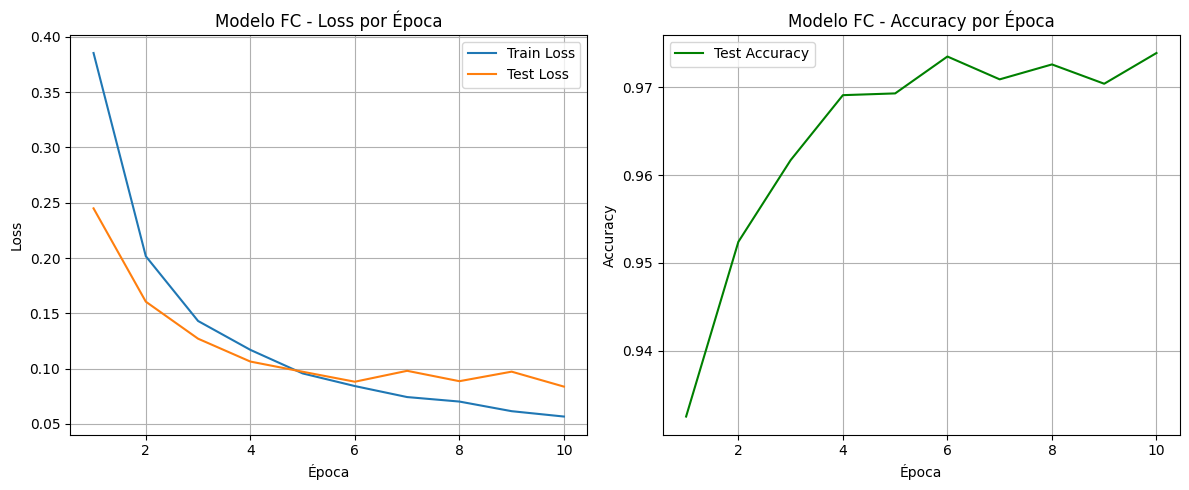

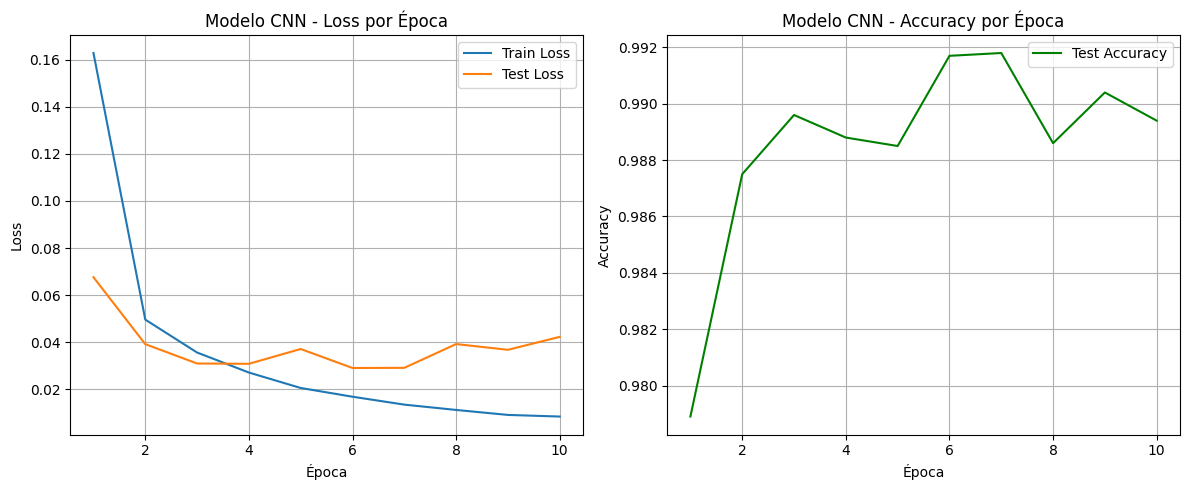

In [9]:
def plot_training_history(train_losses, test_losses, test_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title(f'{model_name} - Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Accuracy por Época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses_fc, test_losses_fc, test_accuracies_fc, "Modelo FC")
plot_training_history(train_losses_cnn, test_losses_cnn, test_accuracies_cnn, "Modelo CNN")

Graficar Curva ROC:

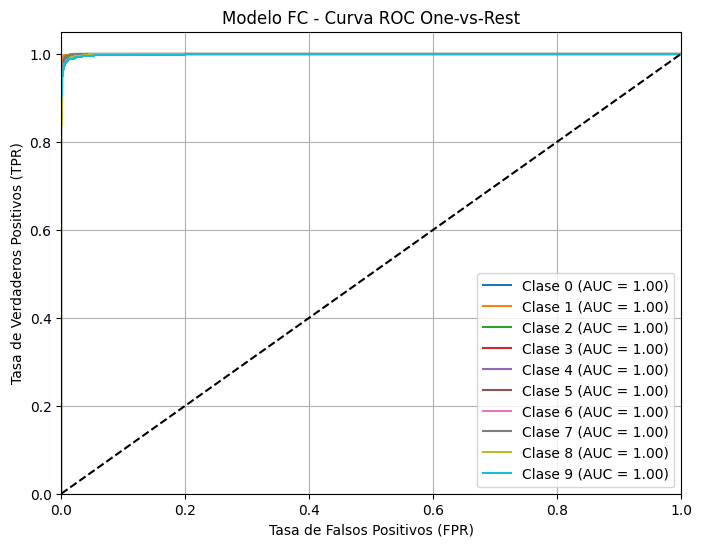

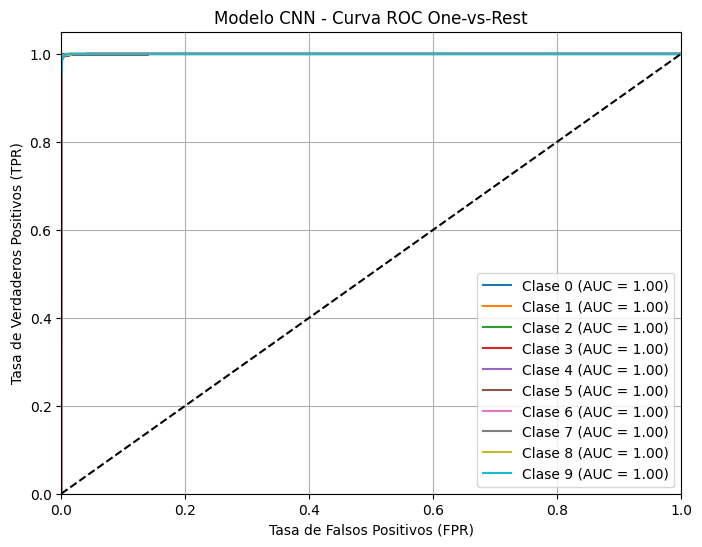

In [10]:
def plot_roc_curve(y_true, y_scores, model_name):
    plt.figure(figsize=(8, 6))
    for i in range(10): # Para cada clase (0 a 9)
        fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
        plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score(np.array(y_true) == i, np.array(y_scores)[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--') # Curva de referencia (aleatoria)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'{model_name} - Curva ROC One-vs-Rest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(y_true_fc, y_scores_fc, "Modelo FC")
plot_roc_curve(y_true_cnn, y_scores_cnn, "Modelo CNN")

Tabla resumen:

In [11]:
import pandas as pd

summary_data = {
    'Modelo': ['FC', 'CNN'],
    'Número de Parámetros': [num_params_fc, num_params_cnn],
    'Accuracy (Test)': [accuracy_fc_eval, accuracy_cnn_eval],
    'AUC (Test)': [auc_fc, auc_cnn],
    'Tiempo de Entrenamiento (s)': [training_time_fc, training_time_cnn]
}

summary_df = pd.DataFrame(summary_data)
print("\n--- Tabla Resumen de Resultados ---")
print(summary_df)




--- Tabla Resumen de Resultados ---
  Modelo  Número de Parámetros  Accuracy (Test)  AUC (Test)  \
0     FC                101770           0.9739    0.999513   
1    CNN                 50186           0.9894    0.999883   

   Tiempo de Entrenamiento (s)  
0                   136.773730  
1                   153.437993  
